In [1]:
import sys,os
sys.path.append("/nlp/scr/zyanzhe/Pix2Code")

from Pix2Code.metrics.visual_score import *
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def show_images_side_by_side(image_file_lst, border_color='black', border_width=0.05):
    n_images = len(image_file_lst)
    # Read the images
    images = [cv2.imread(image_file) for image_file in image_file_lst]

    # Set up the figure and subplots
    plt.figure(figsize=(40, 10))  # Adjusted the size to accommodate four images

    # Adjust subplot parameters to create space (border) between images
    plt.subplots_adjust(wspace=border_width)

    for i in range(n_images):
        plt.subplot(1, n_images, i+1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.axis('off')

    # Set the background color of the figure (acts as border color)
    plt.gcf().set_facecolor(border_color)

    # Display the images
    plt.show()

In [3]:
reference_dir = "../../testset_100"
websight_predictions_dir = "../../predictions_100/websight"
direct_prompting_predictions_dir = "../../predictions_100/gpt4v_direct_prompting"
text_augmented_prompting_predictions_dir = "../../predictions_100/gpt4v_text_augmented_prompting"
revision_prompting_predictions_dir = "../../predictions_100/gpt4v_visual_revision_prompting"
finetuned_predictions_dir = "../../predictions_100/finetuned_v0"

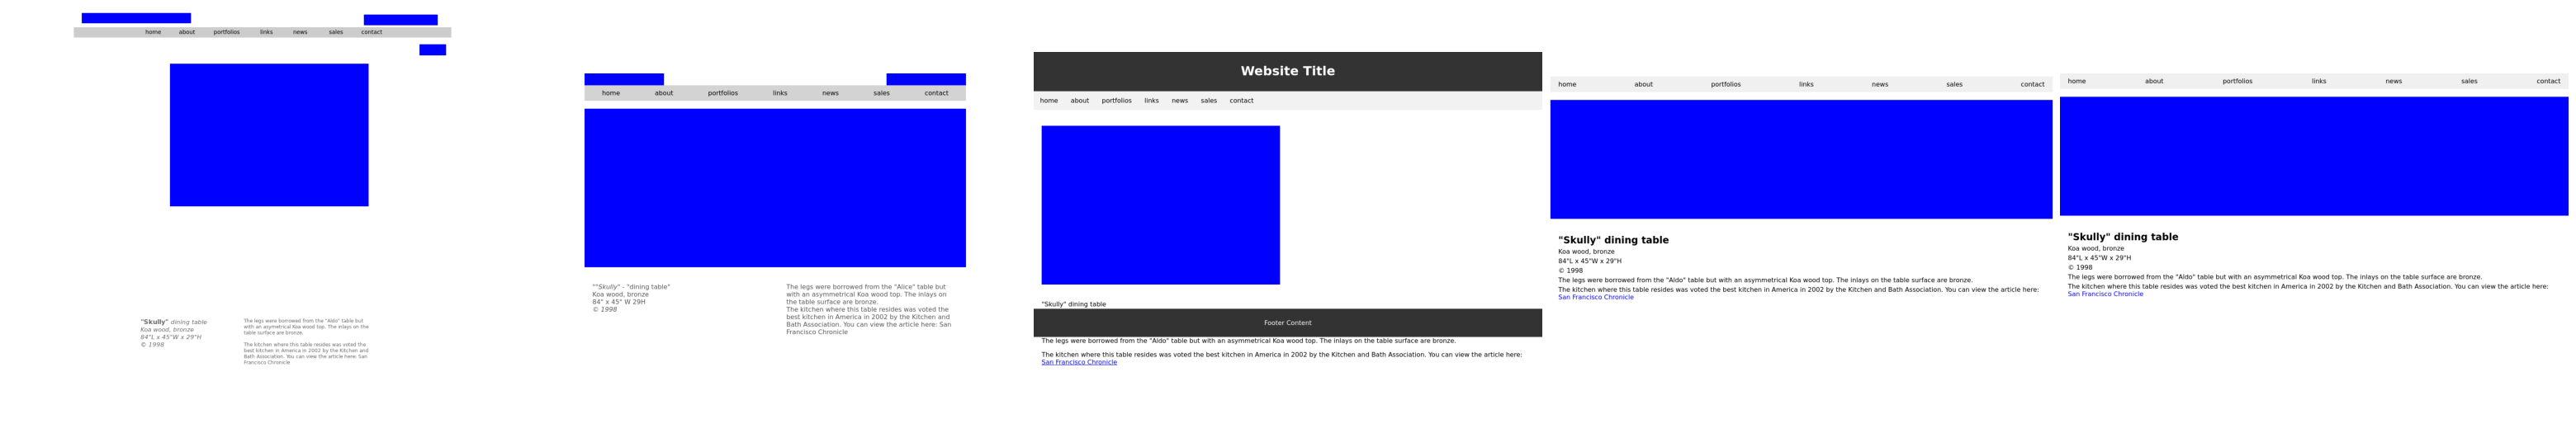

In [4]:
show_images_side_by_side((os.path.join(reference_dir, "2.png"), os.path.join(websight_predictions_dir, "2.png"), os.path.join(direct_prompting_predictions_dir, "2.png"), os.path.join(text_augmented_prompting_predictions_dir, "2.png"), os.path.join(revision_prompting_predictions_dir, "2.png")), border_color='white', border_width=0.01)

In [5]:
from copy import deepcopy
from PIL import Image, ImageDraw
from collections import Counter

def calculate_current_cost(cost_matrix, row_ind, col_ind):
    return cost_matrix[row_ind, col_ind].sum()


def merge_blocks_wo_check(block1, block2):
    # Concatenate text
    merged_text = block1['text'] + " " + block2['text']

    # Calculate bounding box
    x_min = min(block1['bbox'][0], block2['bbox'][0])
    y_min = min(block1['bbox'][1], block2['bbox'][1])
    x_max = max(block1['bbox'][0] + block1['bbox'][2], block2['bbox'][0] + block2['bbox'][2])
    y_max = max(block1['bbox'][1] + block1['bbox'][3], block2['bbox'][1] + block2['bbox'][3])
    merged_bbox = (x_min, y_min, x_max - x_min, y_max - y_min)

    # Average color
    merged_color = tuple(
        (color1 + color2) // 2 for color1, color2 in zip(block1['color'], block2['color'])
    )

    return {'text': merged_text, 'bbox': merged_bbox, 'color': merged_color}

def calculate_current_cost(cost_matrix, row_ind, col_ind):
    return cost_matrix[row_ind, col_ind].tolist()

def find_maximum_matching_debug(A, B, consecutive_bonus, window_size):
    cost_matrix = create_cost_matrix(A, B)
    cost_matrix = adjust_cost_for_context(cost_matrix, consecutive_bonus, window_size)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    current_cost = calculate_current_cost(cost_matrix, row_ind, col_ind)
    return list(zip(row_ind, col_ind)), current_cost, cost_matrix


def remove_indices(lst, indices):
    for index in sorted(indices, reverse=True):
        if index < len(lst):
            lst.pop(index)
    return lst


def merge_blocks_by_list(blocks, merge_list):
    pop_list = []
    while True:
        if len(merge_list) == 0:
            remove_indices(blocks, pop_list)
            return blocks

        i = merge_list[0][0]
        j = merge_list[0][1]
    
        blocks[i] = merge_blocks_wo_check(blocks[i], blocks[j])
        pop_list.append(j)
    
        merge_list.pop(0)
        if len(merge_list) > 0:
            new_merge_list = []
            for k in range(len(merge_list)):
                if merge_list[k][0] != i and merge_list[k][1] != i and merge_list[k][0] != j and merge_list[k][1] != j:
                    new_merge_list.append(merge_list[k])
            merge_list = new_merge_list

def sortFn(value):
    return value[2]


def print_matching(matching, blocks1, blocks2, cost_matrix):
    for i, j in matching:
        print(f"{blocks1[i]} matched with {blocks2[j]}, cost {cost_matrix[i][j]}")


def difference_of_means(list1, list2):
    # Count occurrences of each element in both lists
    counter1 = Counter(list1)
    counter2 = Counter(list2)

    # Adjust for common elements
    for element in set(list1) & set(list2):
        common_count = min(counter1[element], counter2[element])
        counter1[element] -= common_count
        counter2[element] -= common_count

    # Reconstruct lists without common elements
    unique_list1 = [item for item in counter1.elements()]
    unique_list2 = [item for item in counter2.elements()]

    # Calculate means, avoiding division by zero
    mean_list1 = sum(unique_list1) / len(unique_list1) if unique_list1 else 0
    mean_list2 = sum(unique_list2) / len(unique_list2) if unique_list2 else 0

    # Calculate and return the difference of means
    if mean_list1 - mean_list2 > 0:
        if min(unique_list1) > min(unique_list2):
            return mean_list1 - mean_list2
        else:
            return 0.0
    else:
        return mean_list1 - mean_list2


def find_possible_merge(A, B, consecutive_bonus, window_size, debug=False):
    merge_bonus = 0.0
    merge_windows = 1

    while True:
        A_changed = False
        B_changed = False

        matching, current_cost, cost_matrix = find_maximum_matching_debug(A, B, merge_bonus, merge_windows)
        if debug:
            print("Current cost of the solution:", current_cost)
            # print_matching(matching, A, B, cost_matrix)
    
        if len(A) >= 2:
            merge_list = []
            for i in range(len(A) - 1):
                new_A = deepcopy(A)
                new_A[i] = merge_blocks_wo_check(new_A[i], new_A[i + 1])
                new_A.pop(i + 1)
    
                updated_matching, updated_cost, cost_matrix = find_maximum_matching_debug(new_A, B, merge_bonus, merge_windows)
                diff = difference_of_means(current_cost, updated_cost)
                if  diff > 0.05:
                    merge_list.append([i, i + 1, diff])
                    if debug:
                        print(new_A[i]['text'], diff)

                """
                if "Forum Page Spawn Plane Radius" in new_A[i]['text']:
                    print_matching(updated_matching, new_A, B, cost_matrix)
                    print(updated_cost)
                # """
                    
            merge_list.sort(key=sortFn, reverse=True)
            if len(merge_list) > 0:
                A_changed = True
                A = merge_blocks_by_list(A, merge_list)
                updated_matching, updated_cost, _ = find_maximum_matching_debug(A, B, merge_bonus, merge_windows)
                if debug:
                    print("Cost after optimization A:", updated_cost)

        if len(B) >= 2:
            merge_list = []
            for i in range(len(B) - 1):
                new_B = deepcopy(B)
                new_B[i] = merge_blocks_wo_check(new_B[i], new_B[i + 1])
                new_B.pop(i + 1)
    
                updated_matching, updated_cost, cost_matrix = find_maximum_matching_debug(A, new_B, merge_bonus, merge_windows)
                diff = difference_of_means(current_cost, updated_cost)
                if diff > 0.05:
                    merge_list.append([i, i + 1, diff])
                    if debug:
                        print(new_B[i]['text'], diff)

            merge_list.sort(key=sortFn, reverse=True)
            if len(merge_list) > 0:
                B_changed = True
                B = merge_blocks_by_list(B, merge_list)
                updated_matching, updated_cost, _ = find_maximum_matching_debug(A, B, merge_bonus, merge_windows)
                if debug:
                    print("Cost after optimization B:", updated_cost)

        if not A_changed and not B_changed:
            break
    matching, _, _ = find_maximum_matching_debug(A, B, consecutive_bonus, window_size)
    return A, B, matching


def merge_blocks_by_bbox(blocks):
    merged_blocks = {}
    
    # Traverse and merge blocks
    for block in blocks:
        bbox = tuple(block['bbox'])  # Convert bbox to tuple for hashability
        if bbox in merged_blocks:
            # Merge with existing block
            existing_block = merged_blocks[bbox]
            existing_block['text'] += ' ' + block['text']
            existing_block['color'] = [(ec + c) / 2 for ec, c in zip(existing_block['color'], block['color'])]
        else:
            # Add new block
            merged_blocks[bbox] = block

    return list(merged_blocks.values())


def mask_bounding_boxes(image, bounding_boxes):
    width, height = image.size
    draw = ImageDraw.Draw(image)

    for bbox in bounding_boxes:
        x_ratio, y_ratio, w_ratio, h_ratio = bbox
        x = x_ratio * width
        y = y_ratio * height
        w = w_ratio * width
        h = h_ratio * height
        draw.rectangle([x, y, x + w, y + h], fill="white")

    return image


def rescale_and_mask(image_path, blocks):
    # Load the image
    with Image.open(image_path) as img:
        img = mask_bounding_boxes(img, blocks)

        width, height = img.size

        # Determine which side is shorter
        if width < height:
            # Width is shorter, scale height to match the width
            new_size = (width, width)
        else:
            # Height is shorter, scale width to match the height
            new_size = (height, height)

        # Resize the image while maintaining aspect ratio
        img_resized = img.resize(new_size, Image.LANCZOS)

        return img_resized


def calculate_clip_similarity_with_blocks(image_path1, image_path2, blocks1, blocks2):
    # Load and preprocess images
    image1 = preprocess(rescale_and_mask(image_path1, [block['bbox'] for block in blocks1])).unsqueeze(0).to(device)
    image2 = preprocess(rescale_and_mask(image_path2, [block['bbox'] for block in blocks2])).unsqueeze(0).to(device)

    # Calculate features
    with torch.no_grad():
        image_features1 = model.encode_image(image1)
        image_features2 = model.encode_image(image2)

    # Normalize features
    image_features1 /= image_features1.norm(dim=-1, keepdim=True)
    image_features2 /= image_features2.norm(dim=-1, keepdim=True)

    # Calculate cosine similarity
    similarity = (image_features1 @ image_features2.T).item()

    return similarity


def visual_eval_v2_debug(gpt_img, original_img, print_all=False, ocr_free=True, debug=False):
    """
    gpt_img: file to image rendered by gpt gen code. Please place the html file with the same name in the same folder.
    original_img: file to image rendered by the original code. Please place the html file with the same name in the same folder.
    print_all: print matched information or not. Default to False.
    ocr_free: using ocr free approach or not. Default to True.
    """

    if ocr_free:
        gpt_html = gpt_img.replace(".png", ".html")
        original_html = original_img.replace(".png", ".html")
        os.system(f"python3 screenshot_single.py --html {gpt_html} --png {gpt_img}")
        os.system(f"python3 screenshot_single.py --html {original_html} --png {original_img}")

        blocks1 = get_blocks_ocr_free(gpt_img)
        blocks2 = get_blocks_ocr_free(original_img)
        consecutive_bonus, window_size = 0.1, 1
    else:
        blocks1 = get_ocr_blocks(gpt_img)
        blocks2 = get_ocr_blocks(original_img)
        consecutive_bonus, window_size = 0.25, 2

        blocks1 = merge_blocks(blocks1)
        blocks2 = merge_blocks(blocks2)

    if len(blocks1) == 0 or len(blocks2) == 0:
        return 0.0, 0.0, (0.0, 0.0, 0.0, 0.0, 0.0)

    blocks1 = merge_blocks_by_bbox(blocks1)
    blocks2 = merge_blocks_by_bbox(blocks2)
    # matching, cost, _ = find_maximum_matching_debug(blocks1, blocks2, consecutive_bonus, window_size)
    blocks1, blocks2, matching = find_possible_merge(blocks1, blocks2, consecutive_bonus, window_size, debug=debug)
    indices1 = [item[0] for item in matching]
    indices2 = [item[1] for item in matching]

    matched_list = []
    scores = []
    max_areas = []
    matched_areas = []
    matched_text_scores = []
    position_scores = []
    text_color_scores = []

    unmatched_area_1 = 0.0
    for i in range(len(blocks1)):
        if i not in indices1:
            unmatched_area_1 += blocks1[i]['bbox'][2] * blocks1[i]['bbox'][3]
    unmatched_area_2 = 0.0
    for j in range(len(blocks2)):
        if j not in indices2:
            unmatched_area_2 += blocks2[j]['bbox'][2] * blocks2[j]['bbox'][3]
    max_areas.append(max(unmatched_area_1, unmatched_area_2))

    for i, j in matching:
        min_block_area = min(blocks1[i]['bbox'][2] * blocks1[i]['bbox'][3], blocks2[j]['bbox'][2] * blocks2[j]['bbox'][3])
        max_block_area = max(blocks1[i]['bbox'][2] * blocks1[i]['bbox'][3], blocks2[j]['bbox'][2] * blocks2[j]['bbox'][3])
        text_similarity = SequenceMatcher(None, blocks1[i]['text'], blocks2[j]['text']).ratio()
        if text_similarity < 0.5:
            max_areas.append(max_block_area)
            continue
        position_similarity = 1 - calculate_distance(blocks1[i]['bbox'][0] + blocks1[i]['bbox'][2] / 2, \
                                                blocks1[i]['bbox'][1] + blocks1[i]['bbox'][3] / 2, \
                                                blocks2[j]['bbox'][0] + blocks2[j]['bbox'][2] / 2, \
                                                blocks2[j]['bbox'][1] + blocks2[j]['bbox'][3] / 2) / np.sqrt(2)
        # scale to 0.5 ~ 1.0
        text_color_similarity = color_similarity(blocks1[i]['color'], blocks2[j]['color']) * 0.5 + 0.5
        matched_list.append([blocks1[i]['bbox'], blocks2[j]['bbox']])

        # validation check
        if min(blocks1[i]['bbox'][2], blocks2[j]['bbox'][2], blocks1[i]['bbox'][3], blocks2[j]['bbox'][3]) == 0:
            print(f"{blocks1[i]} matched with {blocks2[j]}")
        assert calculate_ratio(blocks1[i]['bbox'][2], blocks2[j]['bbox'][2]) > 0 and calculate_ratio(blocks1[i]['bbox'][3], blocks2[j]['bbox'][3]) > 0, f"{blocks1[i]} matched with {blocks2[j]}"

        scores.append(max_block_area * text_similarity * position_similarity * text_color_similarity)
        matched_areas.append(max_block_area)
        max_areas.append(max_block_area)
        matched_text_scores.append(text_similarity)
        position_scores.append(position_similarity)
        text_color_scores.append(text_color_similarity)

        if debug:
            print(f"{blocks1[i]} matched with {blocks2[j]}")
            print(SequenceMatcher(None, blocks1[i]['text'], blocks2[j]['text']).ratio())
            print("text similarity score", text_similarity)
            print("position score", position_similarity)
            print("color score", text_color_similarity)
            print("----------------------------------")
            pass
    
    if print_all:
        print(f"Matched: {len(location_score)}")
        print("Score:")
        print_stat(scores)

    if debug:
        img1 = cv2.imread(gpt_img)
        img2 = cv2.imread(original_img)
        img1_with_boxes, img2_with_boxes = draw_matched_bboxes(img1, img2, matched_list)
    
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img1_with_boxes, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(img2_with_boxes, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    if len(scores) > 0:
        matched = len(scores)

        final_size_score = np.sum(matched_areas) / np.sum(max_areas)
        final_matched_text_score = np.mean(matched_text_scores)
        final_position_score = np.mean(position_scores)
        final_text_color_score = np.mean(text_color_scores)
        final_clip_score =  calculate_clip_similarity_with_blocks(gpt_img, original_img, blocks1, blocks2)
        final_score = np.sum(scores) / np.sum(max_areas) * final_clip_score
        return matched, final_score, (final_size_score, final_matched_text_score, final_position_score, final_text_color_score, final_clip_score)
    else:
        return 0.0, 0.0, (0.0, 0.0, 0.0, 0.0, 0.0)

16635.html
Current cost of the solution: [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.17777777777777778, -0.9254658385093167, -1.0, -1.0, -0.8943089430894309, -1.0]
Investment Criteria Focused on Double Bottom Line (DBL) returns, DBL Cleantech Capital seeks to partner with outstanding companies that fulfill the following requirements: 0.43668228542370424
Cost after optimization A: [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.9883040935672515, -1.0, -1.0, -0.8943089430894309, -1.0]
Technology-driven products that have the potential to create new market segments or displace current market offerings in clearly defined markets with sustainable high growth rates. Leading-edge or breakthrough technology that drives superior economics. 0.24326718005267522
Cost after optimization B: [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.9883040935672515, -1.0, -1.0, -0.8299319727891157, -1.0]
Current cost of the solution: [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.9883040935672515, -1.0, -1.0, -0.8299319727891157, -1.0]


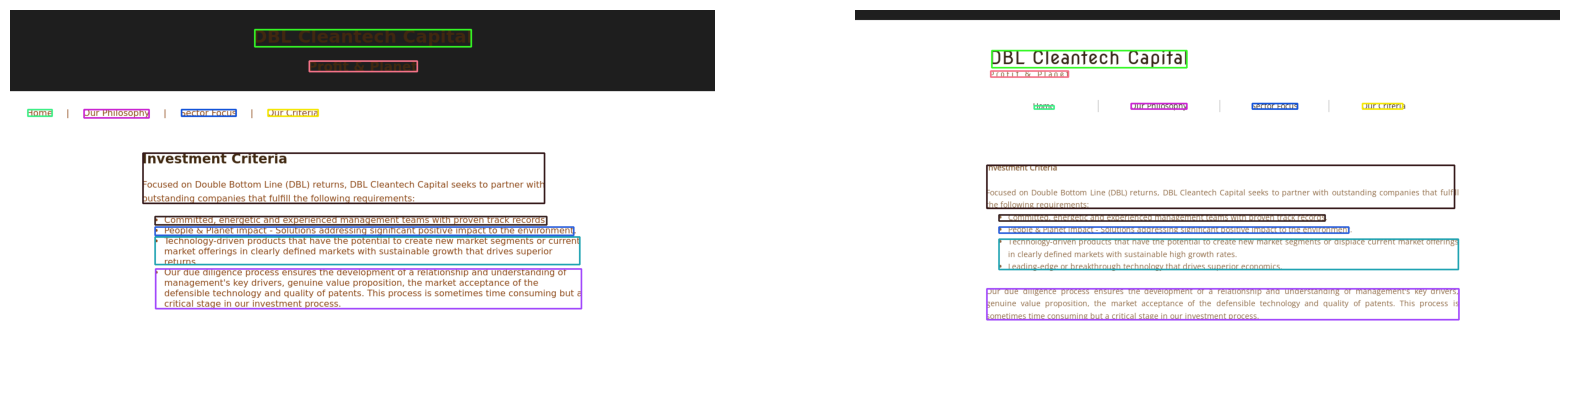

websight score:  0.7971057422452775

final_size_score 1.0
Matched Text Score 0.9834760060323969
Position Score 0.8834056810319296
Text Color Score 0.9192872804168544
CLIP Score 0.9342538714408875
--------------------------------

Current cost of the solution: [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.9254658385093167, -1.0, -1.0, -1.0, -1.0, -1.0]
Investment Criteria Focused on Double Bottom Line (DBL) returns, DBL Cleantech Capital seeks to partner with outstanding companies that fulfill the following requirements: 0.06283825505793472
Cost after optimization A: [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.9883040935672515, -1.0, -1.0, -1.0, -1.0, -1.0]
Current cost of the solution: [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.9883040935672515, -1.0, -1.0, -1.0, -1.0, -1.0]
{'text': 'DBL Cleantech Capital', 'bbox': (0.32734375, 0.03611111111111111, 0.3453125, 0.04722222222222222), 'color': (0, 0, 0)} matched with {'text': 'DBL Cleantech Capital', 'bbox': (0.19375, 0.10416666666666667, 0.2765625, 0

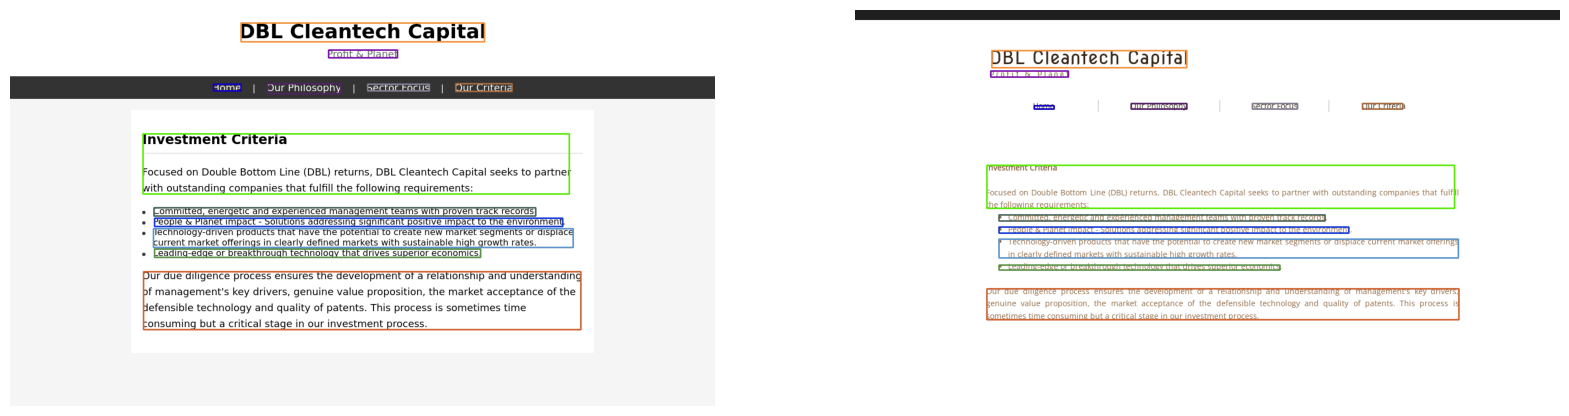

direct prompting score:  0.6909733031924269

final_size_score 0.9999357955731047
Matched Text Score 0.9990253411306043
Position Score 0.9430596101582691
Text Color Score 0.7431352253145086
CLIP Score 0.9093641638755798
--------------------------------

Current cost of the solution: [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.9254658385093167, -1.0, -1.0, -1.0, -1.0, -1.0]
Investment Criteria Focused on Double Bottom Line (DBL) returns, DBL Cleantech Capital seeks to partner with outstanding companies that fulfill the following requirements: 0.06283825505793472
Cost after optimization A: [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.9883040935672515, -1.0, -1.0, -1.0, -1.0, -1.0]
Current cost of the solution: [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.9883040935672515, -1.0, -1.0, -1.0, -1.0, -1.0]
{'text': 'DBL Cleantech Capital', 'bbox': (0.346875, 0.03611111111111111, 0.30703125, 0.043055555555555555), 'color': (0, 0, 0)} matched with {'text': 'DBL Cleantech Capital', 'bbox': (0.19375, 0.10416666

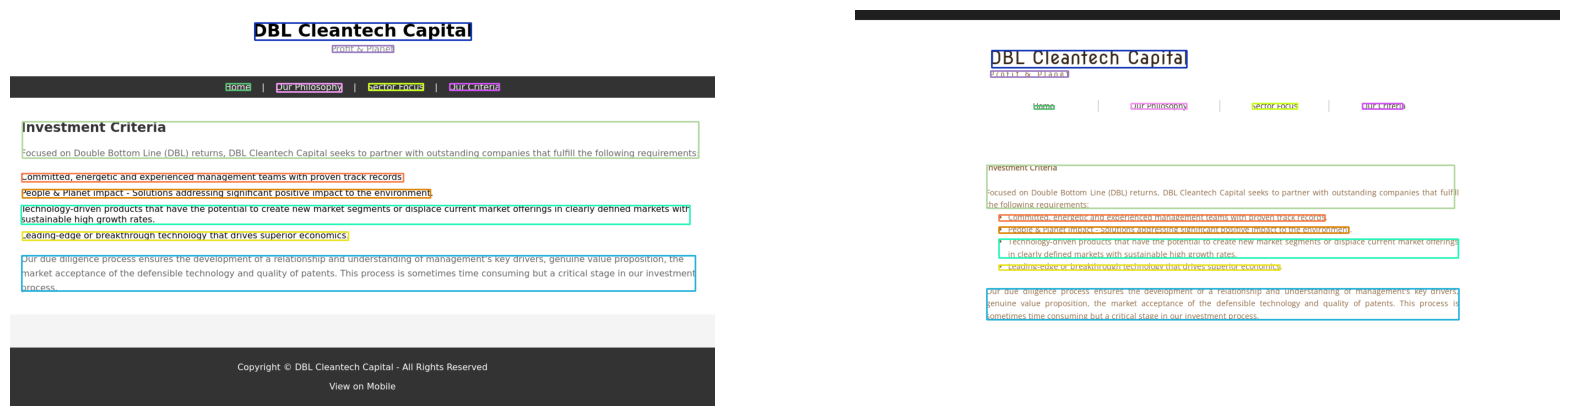

text augmented prompting score:  0.7247773324974673

final_size_score 0.968225054084601
Matched Text Score 0.9990253411306043
Position Score 0.9082919688679558
Text Color Score 0.7643016728781694
CLIP Score 0.9248572587966919
--------------------------------

Current cost of the solution: [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.9254658385093167, -1.0, -1.0, -1.0, -1.0, -1.0]
Investment Criteria Focused on Double Bottom Line (DBL) returns, DBL Cleantech Capital seeks to partner with outstanding companies that fulfill the following requirements: 0.06283825505793472
Cost after optimization A: [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.9883040935672515, -1.0, -1.0, -1.0, -1.0, -1.0]
Current cost of the solution: [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.9883040935672515, -1.0, -1.0, -1.0, -1.0, -1.0]
{'text': 'DBL Cleantech Capital', 'bbox': (0.32734375, 0.034759358288770054, 0.3453125, 0.045454545454545456), 'color': (0, 0, 0)} matched with {'text': 'DBL Cleantech Capital', 'bbox': (0.19375, 0

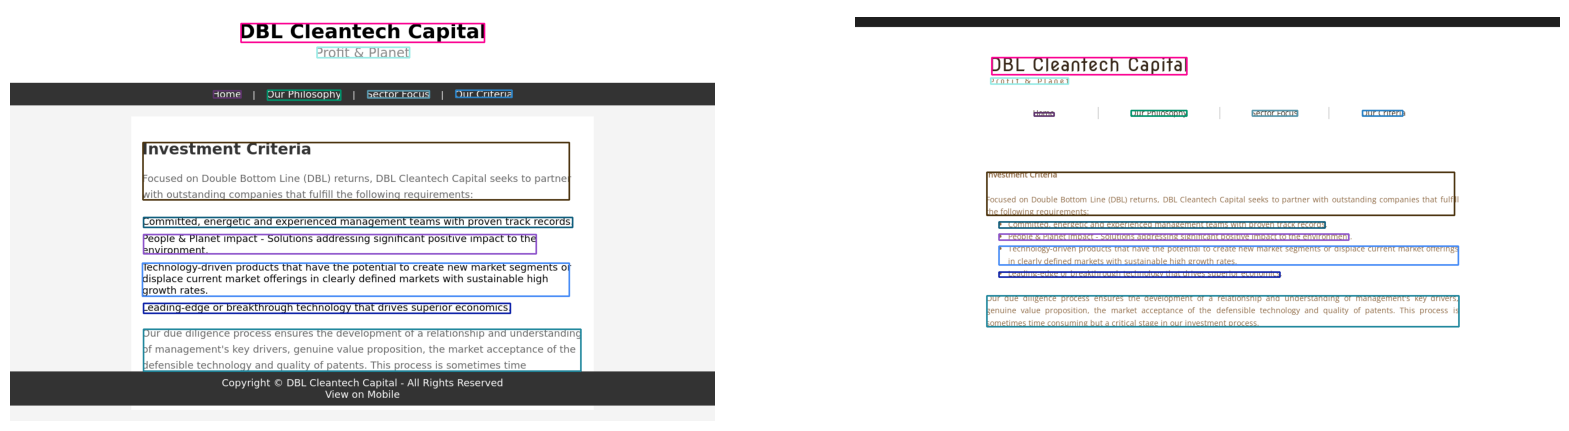

revision prompting score:  0.7117093754928127

final_size_score 0.959873245548461
Matched Text Score 0.9990253411306043
Position Score 0.9373661652067661
Text Color Score 0.7639820385670554
CLIP Score 0.9048567414283752
--------------------------------



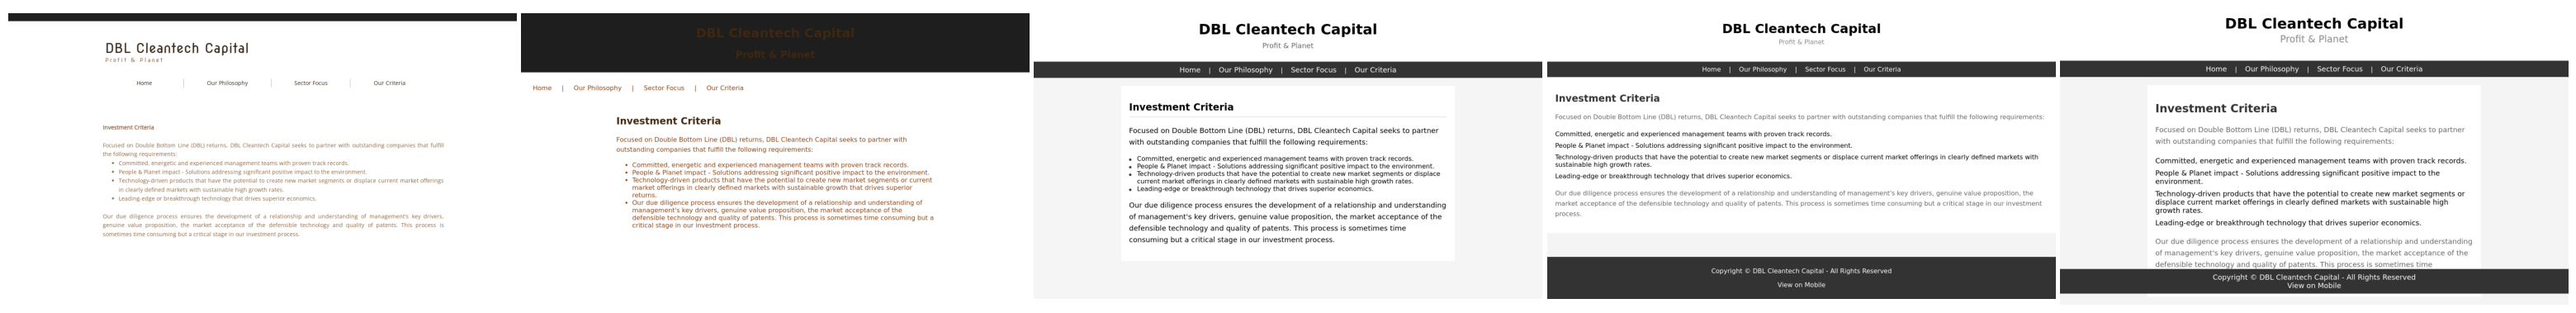

8512.html
Current cost of the solution: [-0.0, -1.0, -0.006389776357827476, -0.13333333333333333, -0.2222222222222222, -0.18181818181818182, -0.2857142857142857, -0.006211180124223602, -0.2857142857142857, -0.2, -0.18181818181818182, -0.2222222222222222, -0.2, -0.2222222222222222, -0.008695652173913044, -1.0, -1.0, -1.0, -0.64, -0.0029245874242740757, -0.32, -1.0, -0.15, -0.15384615384615385, -0.014084507042253521, -0.18181818181818182, -0.13793103448275862, -0.08205128205128205, -0.021352313167259787, -0.17391304347826086, -0.2, -0.3, -0.17391304347826086, -0.23076923076923078, -0.07547169811320754, -0.16, -0.4, -0.1935483870967742]
L a 0.07934625760712716
a n 0.07934625760712716
n S 0.06291824117911074
S P 0.1258741258741259
P a 0.09000000000000002
a d 0.05000000000000002
d i 0.05305039787798407
i c 0.050961570398910555
c o 0.06664784490871445
o m 0.07934625760712716
m e 0.06291824117911074
e t 0.05026245895811113
t o 0.14998117824204782
o r 0.07990880876003811
r y 0.0799130667706559

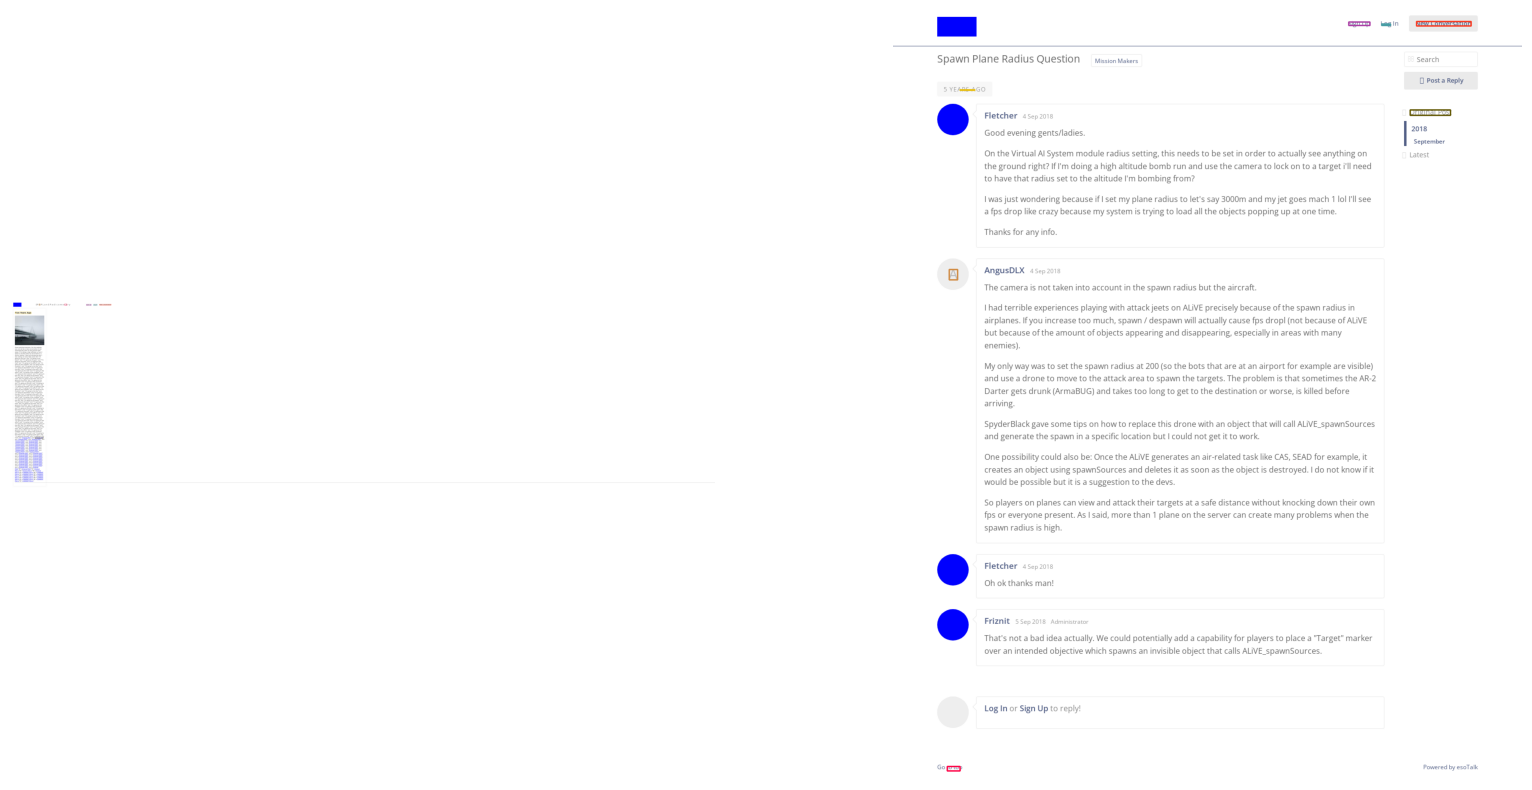

websight score:  0.0005603736493746283

final_size_score 0.001806089208672174
Matched Text Score 0.8771428571428571
Position Score 0.5511672012219734
Text Color Score 0.858959315849927
CLIP Score 0.8015875816345215
--------------------------------

Current cost of the solution: [-0.38095238095238093, -1.0, -0.9440559440559441, -0.6451612903225806, -0.48336252189141854, -0.6451612903225806, -1.0, -0.6666666666666666, -1.0, -0.972972972972973]
Fletcher 4 Sep 2018 0.30483870967741933
AngusDLX 4 Sep 2018 0.30483870967741933
The camera is not taken into account in the spawn radius but the aircraft. I had terrible experiences playing with attack jeets on ALiVE precisely because of the spawn radius in airplanes. If you increase too much, spawn / despawn will actually cause fps dropl (not because of ALiVE but because of the amount of objects appearing and disappearing, especially in areas with many enemies). 0.3153990880157022
Fletcher 4 Sep 2018 0.30483870967741933
Friznit 5 Sep 2018 0.280701

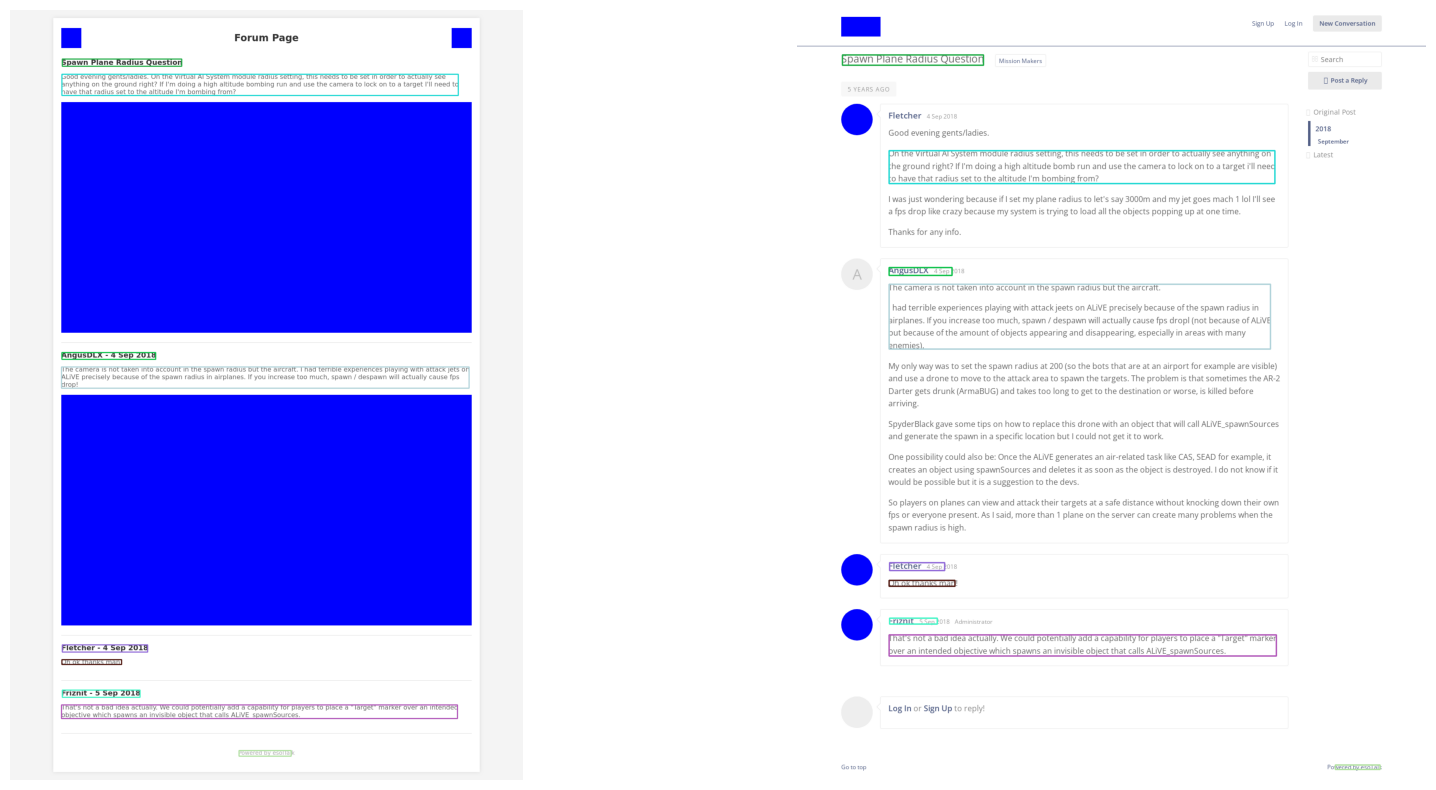

direct prompting score:  0.2931538501247409

final_size_score 0.43889283310023125
Matched Text Score 0.9514621053320744
Position Score 0.9099592995462379
Text Color Score 0.9226125987959666
CLIP Score 0.8223326206207275
--------------------------------

Current cost of the solution: [-1.0, -1.0, -0.6800501882057717, -1.0, -1.0, -0.4050473186119874, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
On the Virtual AI System module radius setting, this needs to be set in order to actually see anything on the ground right? If I'm doing a high altitude bomb run and use the camera to lock on to a target i'll need to have that radius set to the altitude I'm bombing from? I was just wondering because if I set my plane radius to let's say 3000m and my jet goes mach 1 lol I'll see a fps drop like crazy because my system is trying to load all the objects popping up at one time. 0.2721410468539893
I had terrible experiences playing with attack jeets on ALiVE precisely because of the spawn radius in 

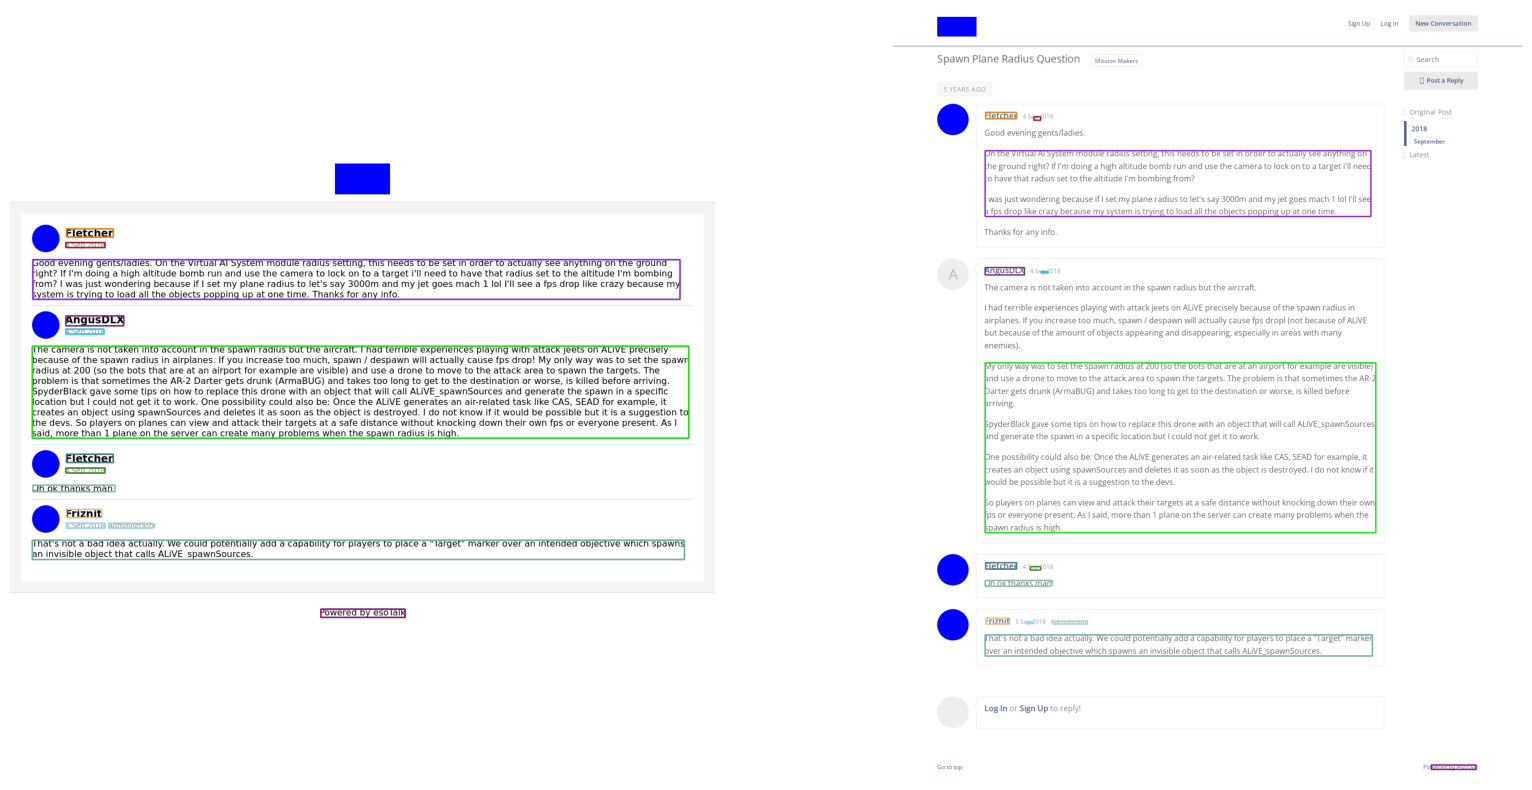

text augmented prompting score:  0.5395013563582213

final_size_score 0.8643175125374511
Matched Text Score 0.9883615076526712
Position Score 0.9185630893336484
Text Color Score 0.8562152070928651
CLIP Score 0.8925321698188782
--------------------------------

Current cost of the solution: [-0.7941176470588235, -1.0, -1.0, -1.0, -1.0, -1.0, -0.6800501882057717, -1.0, -1.0, -0.4050473186119874, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.3870967741935484, -1.0, -1.0, -1.0, -1.0, -0.375]
On the Virtual AI System module radius setting, this needs to be set in order to actually see anything on the ground right? If I'm doing a high altitude bomb run and use the camera to lock on to a target i'll need to have that radius set to the altitude I'm bombing from? I was just wondering because if I set my plane radius to let's say 3000m and my jet goes mach 1 lol I'll see a fps drop like crazy because my system is trying to load all the objects popping up at one time. 0.2721410468539893
I ha

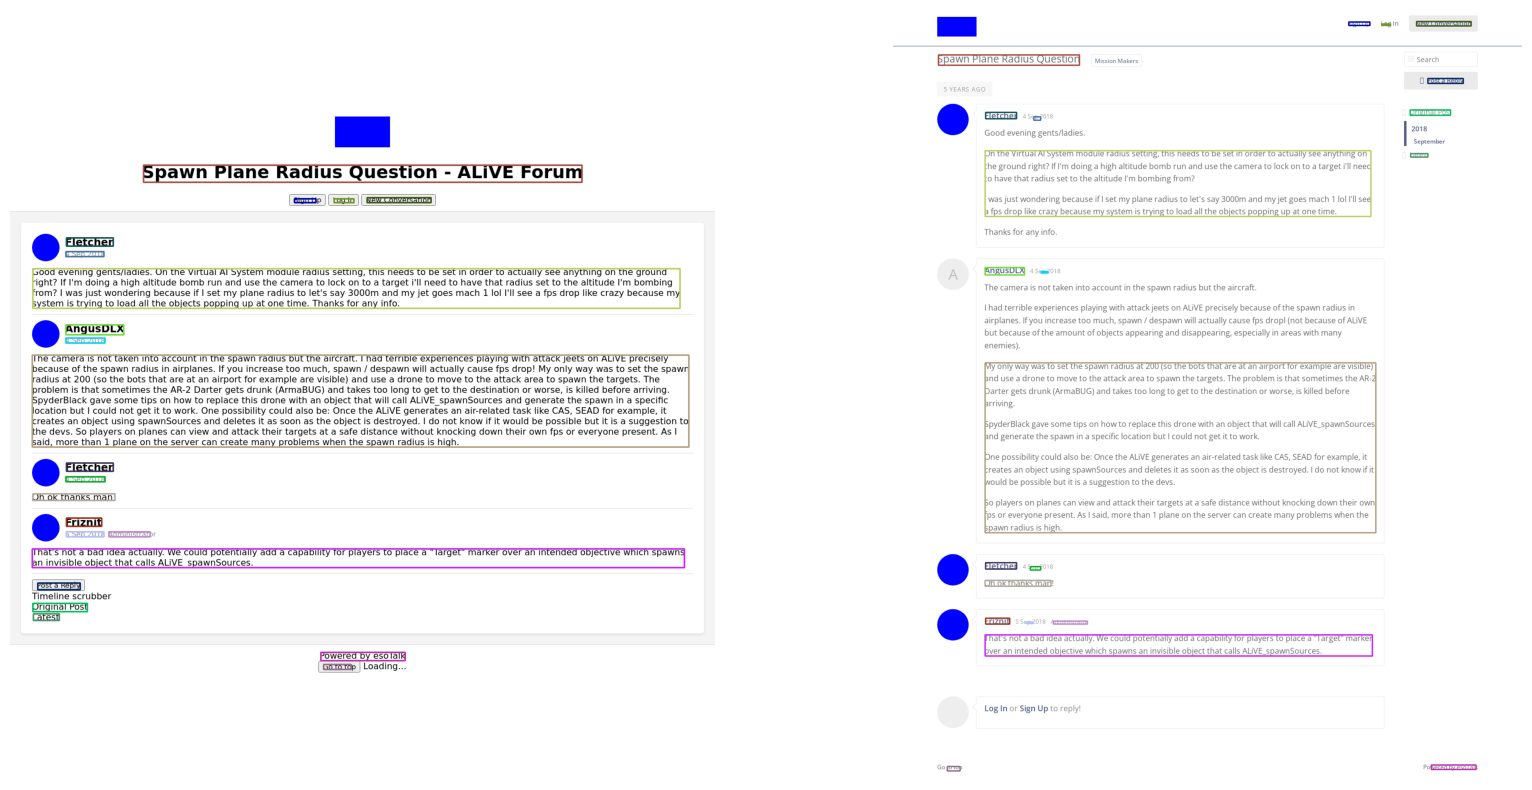

revision prompting score:  0.5326803324081663

final_size_score 0.8601847927645373
Matched Text Score 0.9832353979180101
Position Score 0.7818094282753784
Text Color Score 0.8282578483984707
CLIP Score 0.912603497505188
--------------------------------



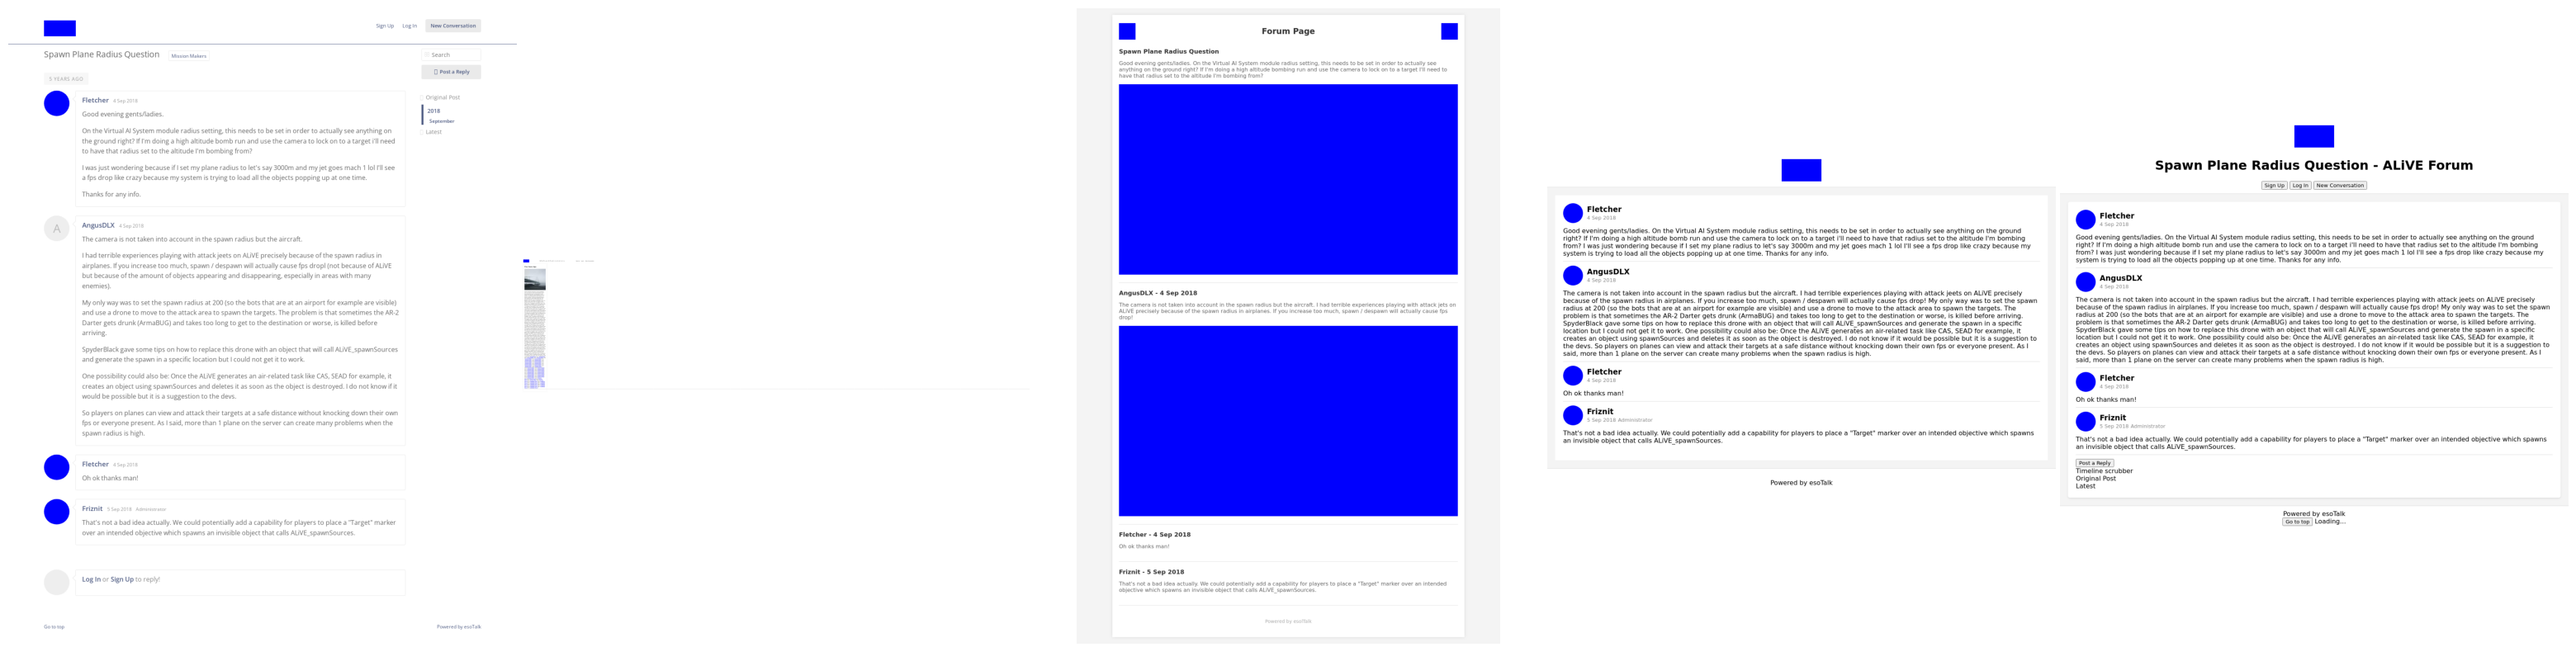

13775.html
Current cost of the solution: [-0.9803921568627451, -1.0, -1.0, -0.7945205479452054, -0.819672131147541, -0.9354838709677419, -1.0, -1.0, -1.0, -1.0, -0.9960474308300395, -1.0, -0.8181818181818182]
{'text': 'Harry Stoshinoff - Artist', 'bbox': (0.13515625, 0.018055555555555554, 0.2171875, 0.03333333333333333), 'color': (85, 85, 85)} matched with {'text': 'Harry Stooshinoff - Artist', 'bbox': (0.13125, 0.024861878453038673, 0.23125, 0.031767955801104975), 'color': (85, 85, 85)}
0.9803921568627451
text similarity score 0.9803921568627451
position score 0.9952015735314276
color score 1.0
----------------------------------
{'text': 'Join Newsletter', 'bbox': (0.13359375, 0.08472222222222223, 0.09296875, 0.019444444444444445), 'color': (86, 86, 86)} matched with {'text': 'Join Newsletter', 'bbox': (0.13515625, 0.07734806629834254, 0.05703125, 0.012430939226519336), 'color': (98, 98, 98)}
1.0
text similarity score 1.0
position score 0.9860795256984077
color score 0.976470588235294

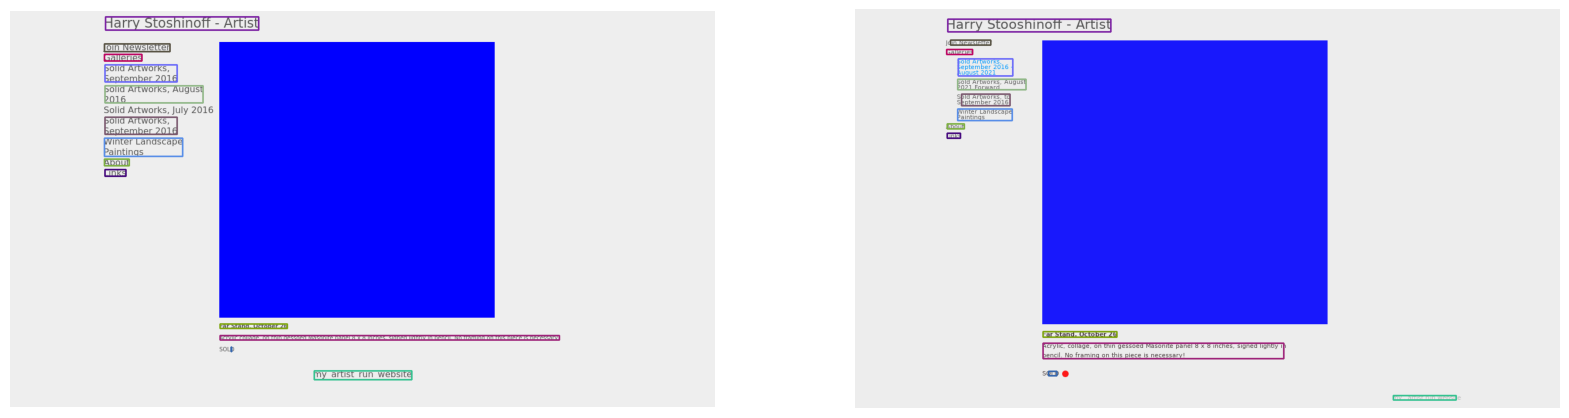

websight score:  0.7690933842019883

final_size_score 0.9387075016102325
Matched Text Score 0.9495613812257763
Position Score 0.9494652429647185
Text Color Score 0.9460274357571913
CLIP Score 0.9662407636642456
--------------------------------

Current cost of the solution: [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
{'text': 'Harry Stooshinoff - Artist', 'bbox': (0.06328125, 0.11944444444444445, 0.1328125, 0.10277777777777777), 'color': (0, 0, 0)} matched with {'text': 'Harry Stooshinoff - Artist', 'bbox': (0.13125, 0.024861878453038673, 0.23125, 0.031767955801104975), 'color': (85, 85, 85)}
1.0
text similarity score 1.0
position score 0.8761943825523152
color score 0.8333333333333334
----------------------------------
{'text': 'Join Newsletter', 'bbox': (0.06328125, 0.2569444444444444, 0.090625, 0.019444444444444445), 'color': (2, 2, 2)} matched with {'text': 'Join Newsletter', 'bbox': (0.13515625, 0.07734806629834254, 0.05703125, 0.0124309392265193

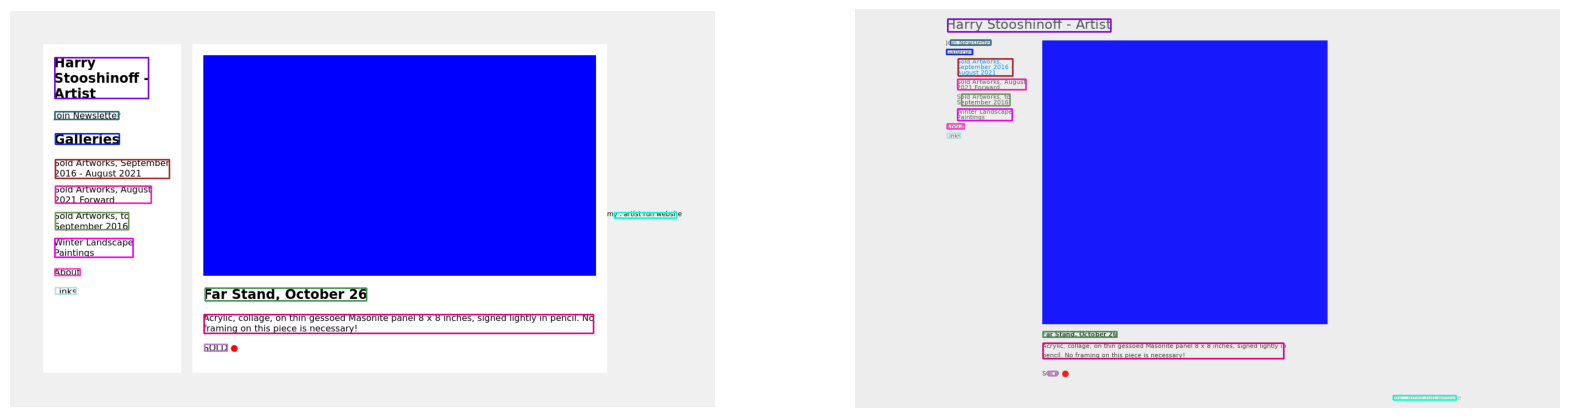

direct prompting score:  0.6706255134962332

final_size_score 0.9983033974116294
Matched Text Score 1.0
Position Score 0.8187635044270655
Text Color Score 0.8018537089926723
CLIP Score 0.9473292231559753
--------------------------------

Current cost of the solution: [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
{'text': 'Harry Stooshinoff - Artist', 'bbox': (0.06482281763180639, 0.041628122109158186, 0.0881590319792567, 0.09158186864014801), 'color': (0, 0, 0)} matched with {'text': 'Harry Stooshinoff - Artist', 'bbox': (0.13125, 0.024861878453038673, 0.23125, 0.031767955801104975), 'color': (85, 85, 85)}
1.0
text similarity score 1.0
position score 0.8970076598165871
color score 0.8333333333333334
----------------------------------
{'text': 'Join Newsletter', 'bbox': (0.06439066551426102, 0.1637372802960222, 0.05142610198789974, 0.012950971322849213), 'color': (2, 2, 2)} matched with {'text': 'Join Newsletter', 'bbox': (0.13515625, 0.07734806629834254

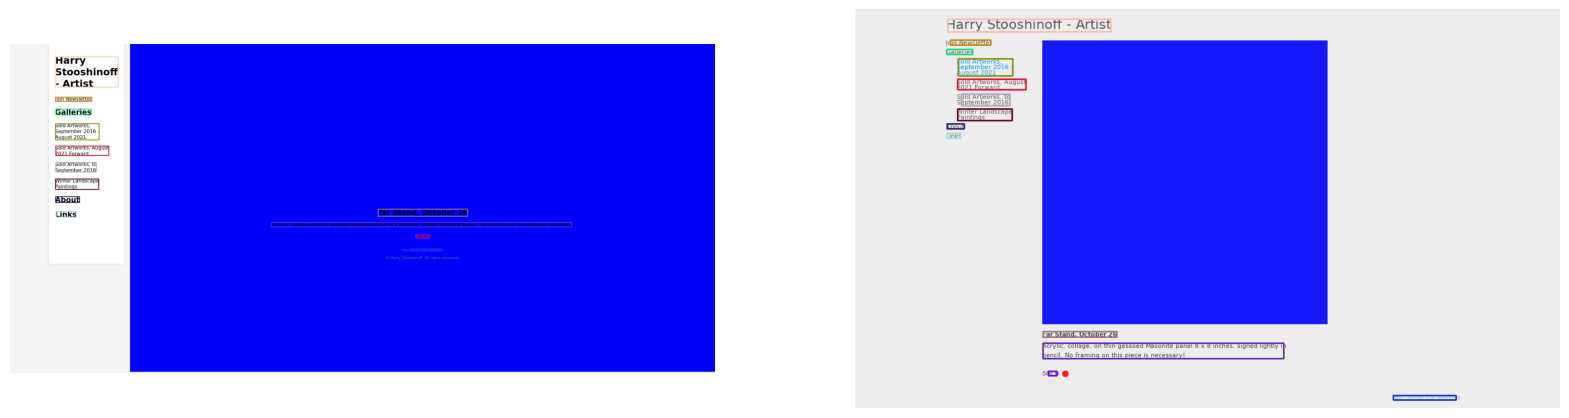

text augmented prompting score:  0.6152845706324067

final_size_score 0.9826144833424247
Matched Text Score 1.0
Position Score 0.8339561133149757
Text Color Score 0.8094318506723993
CLIP Score 0.9191153645515442
--------------------------------

Current cost of the solution: [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
{'text': 'Harry Stooshinoff - Artist', 'bbox': (0.11640625, 0.0, 0.17734375, 0.11583011583011583), 'color': (0, 0, 0)} matched with {'text': 'Harry Stooshinoff - Artist', 'bbox': (0.13125, 0.024861878453038673, 0.23125, 0.031767955801104975), 'color': (85, 85, 85)}
1.0
text similarity score 1.0
position score 0.9680487852967692
color score 0.8333333333333334
----------------------------------
{'text': 'Join Newsletter', 'bbox': (0.11640625, 0.1583011583011583, 0.09296875, 0.018018018018018018), 'color': (2, 2, 2)} matched with {'text': 'Join Newsletter', 'bbox': (0.13515625, 0.07734806629834254, 0.05703125, 0.012430939226519336), 'color'

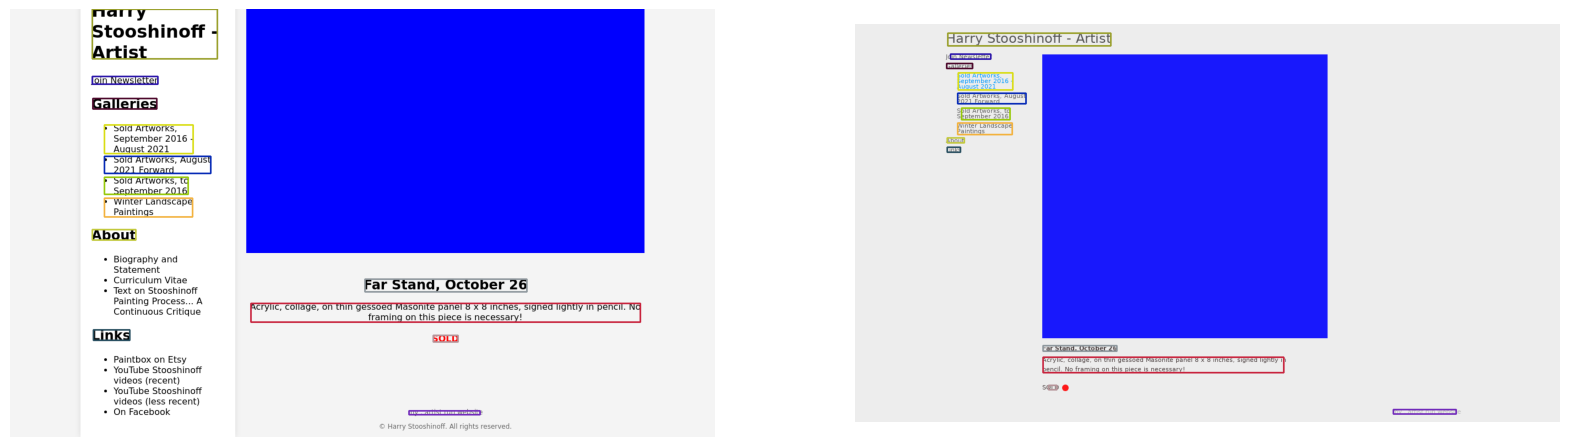

revision prompting score:  0.5018463837405174

final_size_score 0.7264784673744545
Matched Text Score 1.0
Position Score 0.8488662764505961
Text Color Score 0.8099061073926733
CLIP Score 0.9601081013679504
--------------------------------



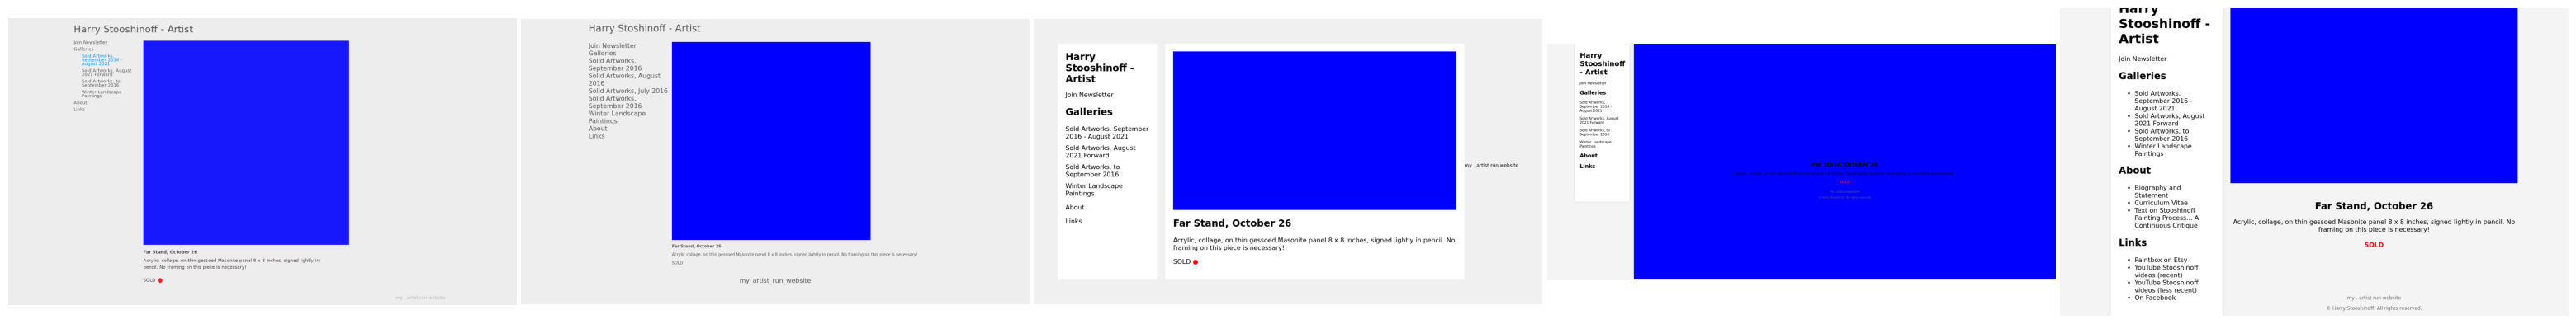

In [6]:
def print_multi_score(multi_score):
    final_size_score, final_matched_text_score, final_position_score, final_text_color_score, final_clip_score = multi_score
    print()
    print("final_size_score", final_size_score)
    print("Matched Text Score", final_matched_text_score)
    print("Position Score", final_position_score)
    print("Text Color Score", final_text_color_score)
    print("CLIP Score", final_clip_score)
    print("--------------------------------\n")

debug = True

for filename in ["16635.html", "8512.html", "13775.html"]:
# for filename in ["13935.html"]:
    print(filename)

    ## websight score 
    matched, final_score, multi_score = visual_eval_v2_debug(os.path.join(websight_predictions_dir, filename.replace(".html", ".png")), os.path.join(reference_dir, filename.replace(".html", ".png")), debug=debug)
    print ("websight score: ", final_score)
    print_multi_score(multi_score)
    
    ## direct prompting score 
    matched, final_score, multi_score = visual_eval_v2_debug(os.path.join(direct_prompting_predictions_dir, filename.replace(".html", ".png")), os.path.join(reference_dir, filename.replace(".html", ".png")), debug=debug)
    print ("direct prompting score: ", final_score)
    print_multi_score(multi_score)

    ## text augmented prompting score
    macthed, final_score, multi_score = visual_eval_v2_debug(os.path.join(text_augmented_prompting_predictions_dir, filename.replace(".html", ".png")), os.path.join(reference_dir, filename.replace(".html", ".png")), debug=debug)
    print ("text augmented prompting score: ", final_score)
    print_multi_score(multi_score)

    ## revision prompting score
    macthed, final_score, multi_score = visual_eval_v2_debug(os.path.join(revision_prompting_predictions_dir, filename.replace(".html", ".png")), os.path.join(reference_dir, filename.replace(".html", ".png")), debug=debug)
    print ("revision prompting score: ", final_score)
    print_multi_score(multi_score)

    show_images_side_by_side((os.path.join(reference_dir, filename.replace(".html", ".png")), os.path.join(websight_predictions_dir, filename.replace(".html", ".png")), os.path.join(direct_prompting_predictions_dir, filename.replace(".html", ".png")), os.path.join(text_augmented_prompting_predictions_dir, filename.replace(".html", ".png")), os.path.join(revision_prompting_predictions_dir, filename.replace(".html", ".png"))), border_color='white', border_width=0.01)

In [11]:
from copy import deepcopy

def visual_eval_v3_multi(input_list, debug=False):
    predict_img_list, original_img = input_list[0], input_list[1]
    predict_blocks_list = []
    for predict_img in predict_img_list:
        predict_html = predict_img.replace(".png", ".html")
        os.system(f"python3 screenshot_single.py --html {predict_html} --png {predict_img}")
        predict_blocks = get_blocks_ocr_free(predict_img)
        predict_blocks_list.append(predict_blocks)
    
    original_html = original_img.replace(".png", ".html")
    os.system(f"python3 screenshot_single.py --html {original_html} --png {original_img}")
    original_blocks = get_blocks_ocr_free(original_img)
    original_blocks = merge_blocks_by_bbox(original_blocks)

    consecutive_bonus, window_size = 0.1, 1

    return_score_list = []

    for k, predict_blocks in enumerate(predict_blocks_list):
        if len(predict_blocks) == 0 or len(original_blocks) == 0:
            return_score_list.append([0.0, 0.0, (0.0, 0.0, 0.0, 0.0, 0.0)])
    
        predict_blocks = merge_blocks_by_bbox(predict_blocks)
        predict_blocks_m, original_blocks_m, matching = find_possible_merge(predict_blocks, deepcopy(original_blocks), consecutive_bonus, window_size, debug=debug)
        indices1 = [item[0] for item in matching]
        indices2 = [item[1] for item in matching]

        matched_list = []
        scores = []
        max_areas = []
        matched_areas = []
        matched_text_scores = []
        position_scores = []
        text_color_scores = []
    
        unmatched_area_1 = 0.0
        for i in range(len(predict_blocks_m)):
            if i not in indices1:
                unmatched_area_1 += predict_blocks_m[i]['bbox'][2] * predict_blocks_m[i]['bbox'][3]
        unmatched_area_2 = 0.0
        for j in range(len(original_blocks_m)):
            if j not in indices2:
                unmatched_area_2 += original_blocks_m[j]['bbox'][2] * original_blocks_m[j]['bbox'][3]
        max_areas.append(max(unmatched_area_1, unmatched_area_2))
    
        for i, j in matching:
            min_block_area = min(predict_blocks_m[i]['bbox'][2] * predict_blocks_m[i]['bbox'][3], original_blocks_m[j]['bbox'][2] * original_blocks_m[j]['bbox'][3])
            max_block_area = max(predict_blocks_m[i]['bbox'][2] * predict_blocks_m[i]['bbox'][3], original_blocks_m[j]['bbox'][2] * original_blocks_m[j]['bbox'][3])
            text_similarity = SequenceMatcher(None, predict_blocks_m[i]['text'], original_blocks_m[j]['text']).ratio()
            if text_similarity < 0.5:
                max_areas.append(max_block_area)
                continue
            position_similarity = 1 - calculate_distance(predict_blocks_m[i]['bbox'][0] + predict_blocks_m[i]['bbox'][2] / 2, \
                                                    predict_blocks_m[i]['bbox'][1] + predict_blocks_m[i]['bbox'][3] / 2, \
                                                    original_blocks_m[j]['bbox'][0] + original_blocks_m[j]['bbox'][2] / 2, \
                                                    original_blocks_m[j]['bbox'][1] + original_blocks_m[j]['bbox'][3] / 2) / np.sqrt(2)
            # scale to 0.5 ~ 1.0
            text_color_similarity = color_similarity(predict_blocks_m[i]['color'], original_blocks_m[j]['color']) * 0.5 + 0.5
            matched_list.append([predict_blocks_m[i]['bbox'], original_blocks_m[j]['bbox']])
    
            # validation check
            if min(predict_blocks_m[i]['bbox'][2], original_blocks_m[j]['bbox'][2], predict_blocks_m[i]['bbox'][3], original_blocks_m[j]['bbox'][3]) == 0:
                print(f"{predict_blocks_m[i]} matched with {original_blocks_m[j]}")
            assert calculate_ratio(predict_blocks_m[i]['bbox'][2], original_blocks_m[j]['bbox'][2]) > 0 and calculate_ratio(predict_blocks_m[i]['bbox'][3], original_blocks_m[j]['bbox'][3]) > 0, f"{predict_blocks_m[i]} matched with {original_blocks_m[j]}"
    
            scores.append(max_block_area * text_similarity * position_similarity * text_color_similarity)
            matched_areas.append(max_block_area)
            max_areas.append(max_block_area)
            matched_text_scores.append(text_similarity)
            position_scores.append(position_similarity)
            text_color_scores.append(text_color_similarity)
    
            if debug:
                print(f"{predict_blocks_m[i]} matched with {original_blocks_m[j]}")
                print(SequenceMatcher(None, predict_blocks_m[i]['text'], original_blocks_m[j]['text']).ratio())
                print("text similarity score", text_similarity)
                print("position score", position_similarity)
                print("color score", text_color_similarity)
                print("----------------------------------")
                pass

        if debug:
            img1 = cv2.imread(predict_img_list[k])
            img2 = cv2.imread(original_img)
            img1_with_boxes, img2_with_boxes = draw_matched_bboxes(img1, img2, matched_list)
        
            plt.figure(figsize=(20, 10))
            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(img1_with_boxes, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(img2_with_boxes, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()
    
        if len(scores) > 0:
            matched = len(scores)
    
            final_size_score = np.sum(matched_areas) / np.sum(max_areas)
            final_matched_text_score = np.mean(matched_text_scores)
            final_position_score = np.mean(position_scores)
            final_text_color_score = np.mean(text_color_scores)
            final_clip_score =  calculate_clip_similarity_with_blocks(predict_img_list[k], original_img, predict_blocks_m, original_blocks_m)
            final_score = np.sum(scores) / np.sum(max_areas) * final_clip_score
            return_score_list.append([matched, final_score, (final_size_score, final_matched_text_score, final_position_score, final_text_color_score, final_clip_score)])
        else:
            return_score_list.append([0.0, 0.0, (0.0, 0.0, 0.0, 0.0, 0.0)])
    return return_score_list

In [ ]:
def print_multi_score(multi_score):
    final_size_score, final_matched_text_score, final_position_score, final_text_color_score, final_clip_score = multi_score
    print()
    print("final_size_score", final_size_score)
    print("Matched Text Score", final_matched_text_score)
    print("Position Score", final_position_score)
    print("Text Color Score", final_text_color_score)
    print("CLIP Score", final_clip_score)
    print("--------------------------------\n")

debug = True

reference_dir = "../../testset_100"

test_dirs = {"websight": "../../predictions_100/websight",\
             "direct_prompting": "../../predictions_100/gpt4v_direct_prompting", \
             "text_augmented_prompting": "../../predictions_100/gpt4v_text_augmented_prompting", \
             "revision_prompting": "../../predictions_100/gpt4v_visual_revision_prompting"}

# for filename in ["16635.html", "8512.html", "13775.html"]:
for filename in ["13935.html"]:
    print(filename)

    input_pred_list = [os.path.join(test_dirs[key], filename.replace(".html", ".png")) for key in test_dirs]
    original = os.path.join(reference_dir, filename.replace(".html", ".png"))

    input_list = [input_pred_list, original]

    return_score_list = visual_eval_v3_multi(input_list, original, debug=debug)
    idx = 0
    for key in test_dirs:
        matched, final_score, multi_score = return_score_list[idx]
        idx += 1

        print(f"{key} score: ", final_score)
        print_multi_score(multi_score)
    
    show_images_side_by_side([os.path.join(reference_dir, filename.replace(".html", ".png"))] + [os.path.join(test_dirs[key], filename.replace(".html", ".png")) for key in test_dirs], border_color='white', border_width=0.01)

In [16]:
from difflib import SequenceMatcher

text_similarity = SequenceMatcher(None, "The camera is not taken into account in the spawn radius but the aircraft. I had terrible experiences playing with attack jeets on ALiVE precisely because of the spawn radius in airplanes. If you increase too much, spawn / despawn will actually cause fps drop! My only way was to set the spawn radius at 200 (so the bots that are at an airport for example are visible) and use a drone to move to the attack area to spawn the targets. The problem is that sometimes the AR-2 Darter gets drunk (ArmaBUG) and takes too long to get to the destination or worse, is killed before arriving. SpyderBlack gave some tips on how to replace this drone with an object that will call ALiVE_spawnSources and generate the spawn in a specific location but I could not get it to work. One possibility could also be: Once the ALiVE generates an air-related task like CAS, SEAD for example, it creates an object using spawnSources and deletes it as soon as the object is destroyed. I do not know if it would be possible but it is a suggestion to the devs. So players on planes can view and attack their targets at a safe distance without knocking down their own fps or everyone present. As I said, more than 1 plane on the server can create many problems when the spawn radius is high.", \
                                  "My only way was to set the spawn radius at 200 (so the bots that are at an airport for example are visible) and use a drone to move to the attack area to spawn the targets. The problem is that sometimes the AR-2 Darter gets drunk (ArmaBUG) and takes too long to get to the destination or worse, is killed before arriving. SpyderBlack gave some tips on how to replace this drone with an object that will call ALiVE_spawnSources and generate the spawn in a specific location but I could not get it to work. One possibility could also be: Once the ALiVE generates an air-related task like CAS, SEAD for example, it creates an object using spawnSources and deletes it as soon as the object is destroyed. I do not know if it would be possible but it is a suggestion to the devs. So players on planes can view and attack their targets at a safe distance without knocking down their own fps or everyone present. As I said, more than 1 plane on the server can create many problems when the spawn radius is high.").ratio()
print(text_similarity)

0.8848698720776357


In [13]:
from difflib import SequenceMatcher

text_similarity = SequenceMatcher(None, "The camera is not taken into account in the spawn radius but the aircraft. I had terrible experiences playing with attack jets on ALiVE precisely because of the spawn radius in airplanes. If you increase too much, spawn / despawn will actually cause fps drop!", \
                                  "I had terrible experiences playing with attack jeets on ALiVE precisely because of the spawn radius in airplanes. If you increase too much, spawn / despawn will actually cause fps dropl (not because of ALiVE but because of the amount of objects appearing and disappearing, especially in areas with many enemies).").ratio()
print(text_similarity)

0.48336252189141854


In [20]:
from difflib import SequenceMatcher

text_similarity = SequenceMatcher(None, "The camera is not taken into account in the spawn radius but the aircraft. I had terrible experiences playing with attack jets on ALiVE precisely because of the spawn radius in airplanes. If you increase too much, spawn / despawn will actually cause fps drop!", \
                                  "The camera is not taken into account in the spawn radius but the aircraft." + generate_random_string(length=10)).ratio()
print(text_similarity)

0.44314868804664725


In [16]:
import random
import string

def generate_random_string(length=10):
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for _ in range(length))

text_similarity = SequenceMatcher(None, generate_random_string(), generate_random_string()).ratio()
print(text_similarity)

0.2


In [27]:
import numpy as np

def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

def calculate_similarity_with_levenshtein(a, b, c):
    # Function to calculate normalized similarity
    def normalized_similarity(s1, s2):
        dist = levenshtein_distance(s1, s2)
        # Normalize by the length of the longer string
        return 1 - dist / max(len(s1), len(s2))

    print(len(a))
    print(len(b))
    print(len(c))
    print()

    print(levenshtein_distance(a, c))
    print(levenshtein_distance(b, c))
    print(levenshtein_distance(a + b, c))
    print()

    sim_a_c = normalized_similarity(a, c)
    sim_b_c = normalized_similarity(b, c)
    sim_ab_c = normalized_similarity(a + b, c)

    # Decide if merging a and b is better
    merge_better = sim_ab_c > max(sim_a_c, sim_b_c)

    return sim_a_c, sim_b_c, sim_ab_c, merge_better

# Example usage
a = "The camera is not taken into account in the spawn radius but the aircraft."
b = "I had terrible experiences playing with attack jeets on ALiVE precisely because of the spawn radius in airplanes. If you increase too much, spawn / despawn will actually cause fps dropl (not because of ALiVE but because of the amount of objects appearing and disappearing, especially in areas with many enemies)."
c = "The camera is not taken into account in the spawn radius but the aircraft. I had terrible experiences playing with attack jets on ALiVE precisely because of the spawn radius in airplanes. If you increase too much, spawn / despawn will actually cause fps drop!"
similarities = calculate_similarity_with_levenshtein(a, b, c)
print(similarities)

74
312
259

185
204
130

(0.2857142857142857, 0.34615384615384615, 0.6632124352331606, True)


In [34]:
# Example usage
a = "The camera is not taken into account in the spawn radius but the aircraft."
b = generate_random_string(312)
c = "The camera is not taken into account in the spawn radius but the aircraft. I had terrible experiences playing with attack jets on ALiVE precisely because of the spawn radius in airplanes. If you increase too much, spawn / despawn will actually cause fps drop!"
similarities = calculate_similarity_with_levenshtein(a, b, c)
print(similarities)

74
312
259

185
270
263

(0.2857142857142857, 0.13461538461538458, 0.31865284974093266, True)


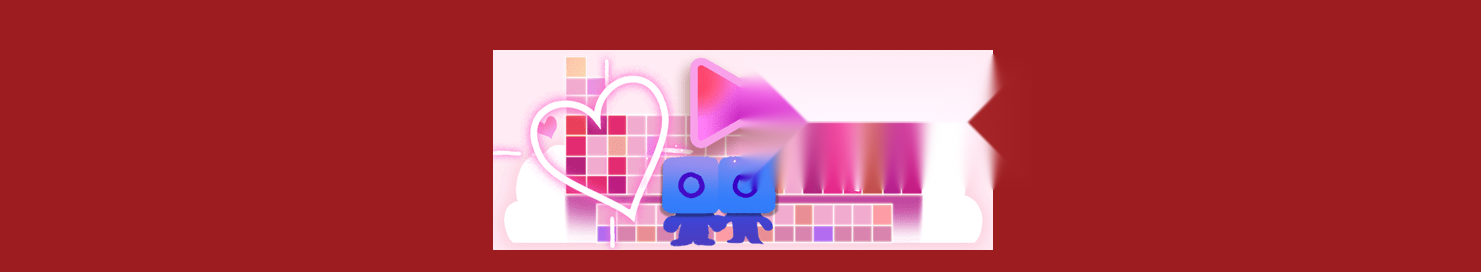

In [15]:
from PIL import Image, ImageDraw

def mask_bounding_boxes(image, bounding_boxes):
    """
    Masks the specified bounding boxes in the image with white color.
    The bounding box coordinates are given as ratios of the image size.

    :param image: A PIL Image object.
    :param bounding_boxes: A list of bounding boxes in the format (x_ratio, y_ratio, h_ratio, w_ratio).
    :return: A PIL Image object with the bounding boxes masked.
    """
    width, height = image.size
    draw = ImageDraw.Draw(image)

    for bbox in bounding_boxes:
        x_ratio, y_ratio, h_ratio, w_ratio = bbox
        x = x_ratio * width
        y = y_ratio * height
        w = w_ratio * width
        h = h_ratio * height
        draw.rectangle([x, y, x + w, y + h], fill="white")

    return image


import cv2
import numpy as np

def mask_bounding_boxes_with_inpainting(image, bounding_boxes):
    # Convert PIL image to OpenCV format
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # Create a black mask
    mask = np.zeros(image_cv.shape[:2], dtype=np.uint8)

    height, width = image_cv.shape[:2]

    # Draw white rectangles on the mask
    for bbox in bounding_boxes:
        x_ratio, y_ratio, h_ratio, w_ratio = bbox
        x = int(x_ratio * width)
        y = int(y_ratio * height)
        w = int(w_ratio * width)
        h = int(h_ratio * height)
        mask[y:y+h, x:x+w] = 255

    # Use inpainting
    inpainted_image = cv2.inpaint(image_cv, mask, 3, cv2.INPAINT_TELEA)

    # Convert back to PIL format
    inpainted_image_pil = Image.fromarray(cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB))

    return inpainted_image_pil

image = Image.open('/nlp/scr/zyanzhe/test.png')
display(mask_bounding_boxes_with_inpainting(image, [[0.5, 0.2, 0.5, 0.2]]))

In [23]:
a = [-0.38095238095238093, -1.0, -0.9440559440559441, -0.6451612903225806, -0.48336252189141854, -0.6451612903225806, -1.0, -0.6666666666666666, -1.0, -0.972972972972973]
b = [-0.38095238095238093, -1.0, -0.9440559440559441, -0.6451612903225806, -0.48336252189141854, -0.6451612903225806, -1.0, -0.6666666666666666, -0.9521531100478469]
difference_of_means(a, b)

0.0